In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle

import cobra
import snek

# Figure 1

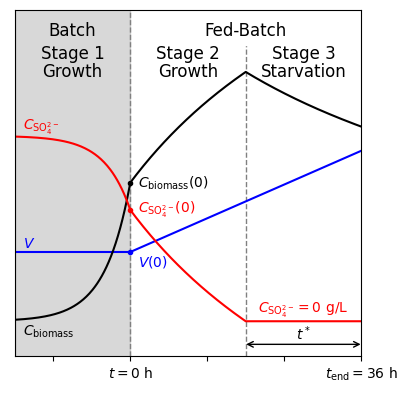

In [3]:
fig = plt.figure(dpi=100,figsize=(5,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111,box_aspect=1)

len_batch= 15
len_grow = 15
len_star = 15
len_total= len_batch+len_grow+len_star
t = np.linspace(-len_batch,len_grow+len_star,len_total*10+1)
V0 = .5
V = np.clip(np.ones(len(t))*V0+t*0.013,a_max=np.inf,a_min=V0)

X = np.ones(len(t))
X[:len_batch*10+1] = np.exp(0.3023880520846277*np.linspace(0,len_batch,len_batch*10+1))
X[len_batch*10+1:] = X[len_batch*10+1:]*np.max(X[:len_batch*10+1]) + np.max(X[:len_batch*10+1])*t[len_batch*10+1:]*.1
X[(len_batch+len_grow)*10+1:] = X[(len_batch+len_grow)*10]

V_shift = -.3+0.03820225
V = V/np.max(V)
plt.plot(t,V+V_shift,color="b",label=r"$V$")
#V = np.clip(V,a_min=.6,a_max=np.inf)
CX = X/V/np.max(X/V)*1.08
plt.plot(t,CX,color="k",label=r"$C_{\rm biomass}$")
CS = (1-X/np.max(X))/(V/np.max(V))/np.max((1-X/np.max(X))/(V/np.max(V)))*.8
plt.plot(t,CS,color="r",label=r"$C_{\rm SO_4^{2-}}$")

plt.xlim(-15,30)
plt.ylim(-.15,1.35)

va = "top"
fs = 12
h = 1.3
plt.text(-7.5,h, "Batch",va=va,fontsize=fs,ha="center")
plt.text(15,h, "Fed-Batch",va=va,fontsize=fs,ha="center",backgroundcolor="w")
h = 1.12
plt.text(-7.5,h, "Growth",va=va,fontsize=fs,ha="center")
plt.text( 7.5,h, "Growth",va=va,fontsize=fs,ha="center")
plt.text(15+7.5,h, "Starvation",va=va,fontsize=fs,ha="center")
h = 1.2
plt.text(-7.5,h, "Stage 1",va=va,fontsize=fs,ha="center")
plt.text( 7.5,h, "Stage 2",va=va,fontsize=fs,ha="center")
plt.text(15+7.5,h, "Stage 3",va=va,fontsize=fs,ha="center")


ax1.axvline( 0,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.axvline(15,zorder=-1,color='grey',linestyle='--',linewidth=1)
plt.fill_between([14,16],[1.3,1.3],[2,2],color="w")

left = 14.7
right = 30.3
height = -.1
plt.annotate("", xy=(left, height), xytext=(right, height),  arrowprops=dict(arrowstyle='<->',color='k'))
plt.text(15+7.5,-.08,r"$t^*$",ha="center")
plt.scatter(0,CX[t==0],marker=".",color="k")

plt.text(1,CX[t==0],r"$C_{\rm biomass}(0)$",color="k",va="center")
plt.text(-14,CX[t==-15]-.05,r"$C_{\rm biomass}$",color="k",va="center")
plt.scatter(0,CS[t==0],marker=".",color="r")
plt.text(1,CS[t==0],r"$C_{\rm SO_4^{2-}}(0)$",color="r",va="center")
plt.text(-14,CS[t==-15]+.04,r"$C_{\rm SO_4^{2-}}$",color="r",va="center")
plt.text(22.5,.04,r"$C_{\rm SO_4^{2-}} = 0$ g/L",color="r",ha="center")
plt.scatter(0,V[t==0]+V_shift,marker=".",color="b")
plt.text(1   ,V[t==0]+V_shift-.06,r"$V(0)$",color="b")
plt.text(-14 ,V[t==-15]+V_shift+.02,r"$V$",color="b")
plt.fill_between([-15,0],[-2,-2],[2,2],color="grey",alpha=.3,zorder=-2)

fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
ax1.set_yticks([])
ax1.set_xticks([-10,0,10,20,30])
ax1.set_xticklabels(["",r"$t = 0$ h","","",r"$t_{\rm end}= 36$ h"])
plt.show()

# Figure 2

## Biomass Uptake Fluxes

In [2]:
ecoli = cobra.io.read_sbml_model('iML1515_pDNA.xml')
ecoli.solver = 'cplex'
max_growth_rate = ecoli.slim_optimize()

snek.find_biomass_reaction(ecoli)
biomass = 'BIOMASS_Ec_iML1515_core_75p37M'
summary = ecoli.summary()

# turn off all medium components that are not present 
# in the pFBA solution, so they do not interfere
for reaction in ecoli.medium:
    # we make an exception for water molecules
    if reaction in ['EX_h_e','EX_h2o_e'] or reaction in summary.uptake_flux.index:
        pass
    else:
        snek.set_bounds(ecoli,reaction,lb=0)

summary2 = ecoli.summary()
# check if the solution does not change
assert np.all(np.isclose(summary.uptake_flux['flux'],summary2.uptake_flux['flux'],atol=ecoli.tolerance,rtol=0))

In [3]:
# do FVA
with ecoli as model:
    fva_result = cobra.flux_analysis.flux_variability_analysis(model)

In [4]:
all_metabolite_labels = [r'Ca$^{2+}$', r'Cl$^{-}$', r'Co$^{2+}$', r'Cu$^{2+}$', r'Fe$^{2+}$', r'Glc', r'K$^{+}$', r'Mg$^{2+}$', r'Mn$^{2+}$', r'MoO$_4^{2-}$', r'NH$_4^+$', r'Ni$^{2+}$', r'O$_2$', r'HPO$_4^{2-}$', r'SO$_4^{2-}$', r'Zn$^{2+}$']
metabolites = sorted(['EX_cu2_e','EX_so4_e','EX_mn2_e','EX_ni2_e','EX_zn2_e','EX_cobalt2_e','EX_fe2_e','EX_cl_e','EX_k_e','EX_ca2_e','EX_mg2_e','EX_mobd_e'])
tmp = summary.uptake_flux.copy() #.loc[metabolites,:]
tmp.insert(0,'label',all_metabolite_labels)
tmp = tmp.sort_values('flux',ascending=False)

In [5]:
mins = []
maxs = []
for m in tmp.index:
    mins.append(-fva_result.loc[m,'minimum'])
    maxs.append(-fva_result.loc[m,'maximum'])
    
tmp.insert(4,'max',mins)
tmp.insert(5,'min',maxs)
tmp

,label,flux,reaction,metabolite,max,min
EX_o2_e,O$_2$,22.131763,EX_o2_e,o2_e,272.128242,22.131763
EX_glc__D_e,Glc,10.000000,EX_glc__D_e,glc__D_e,10.000000,10.000000
EX_nh4_e,NH$_4^+$,9.471495,EX_nh4_e,nh4_e,9.471495,9.471495
EX_pi_e,HPO$_4^{2-}$,0.845957,EX_pi_e,pi_e,0.845957,0.845957
EX_so4_e,SO$_4^{2-}$,0.220845,EX_so4_e,so4_e,0.220845,0.220845
EX_k_e,K$^{+}$,0.171184,EX_k_e,k_e,0.171184,0.171184
EX_fe2_e,Fe$^{2+}$,0.014085,EX_fe2_e,fe2_e,1000.000000,0.014085
EX_mg2_e,Mg$^{2+}$,0.007608,EX_mg2_e,mg2_e,0.007608,0.007608
EX_ca2_e,Ca$^{2+}$,0.004565,EX_ca2_e,ca2_e,0.004565,0.004565
EX_cl_e,Cl$^{-}$,0.004565,EX_cl_e,cl_e,0.004565,0.004565


## pDNA Synthesis Fluxes

In [6]:
with ecoli:
    snek.set_objective(ecoli,'pDNA_synthesis','max')
    dna_summary = ecoli.summary()
    dna_fva_result = cobra.flux_analysis.flux_variability_analysis(ecoli)
    print(ecoli.slim_optimize())

0.30851746050253376


In [7]:
all_metabolite_labels = [r'Ca$^{2+}$', r'Cl$^{-}$', r'Co$^{2+}$', r'Cu$^{2+}$', r'Fe$^{2+}$', r'Glc', r'K$^{+}$', r'Mg$^{2+}$', r'Mn$^{2+}$', r'MoO$_4^{2-}$', r'NH$_4^+$', r'Ni$^{2+}$', r'O$_2$', r'HPO$_4^{2-}$', r'SO$_4^{2-}$', r'Zn$^{2+}$']
metabolites = sorted(['EX_cu2_e','EX_so4_e','EX_mn2_e','EX_ni2_e','EX_zn2_e','EX_cobalt2_e','EX_fe2_e','EX_cl_e','EX_k_e','EX_ca2_e','EX_mg2_e','EX_mobd_e'])
tmp2 = summary.uptake_flux.copy() #.loc[metabolites,:]
tmp2.insert(0,'label',all_metabolite_labels)
tmp2 = tmp2.sort_values('flux',ascending=False)
tmp2['flux'] = 0

In [8]:
mins = []
maxs = []
for m in tmp.index:
    if m in dna_summary.uptake_flux.index:
        tmp2.loc[m,'flux'] = dna_summary.uptake_flux.loc[m,'flux']
    mins.append(-dna_fva_result.loc[m,'minimum'])
    maxs.append(-dna_fva_result.loc[m,'maximum'])
tmp2.insert(4,'max',mins)
tmp2.insert(5,'min',maxs)
tmp2

,label,flux,reaction,metabolite,max,min
EX_o2_e,O$_2$,19.275695,EX_o2_e,o2_e,2.692757e+02,1.927570e+01
EX_glc__D_e,Glc,10.000000,EX_glc__D_e,glc__D_e,1.000000e+01,1.000000e+01
EX_nh4_e,NH$_4^+$,18.511048,EX_nh4_e,nh4_e,1.851105e+01,1.851105e+01
EX_pi_e,HPO$_4^{2-}$,4.936279,EX_pi_e,pi_e,4.936279e+00,4.936279e+00
EX_so4_e,SO$_4^{2-}$,0.000000,EX_so4_e,so4_e,1.356693e-13,-0.000000e+00
EX_k_e,K$^{+}$,0.000000,EX_k_e,k_e,-0.000000e+00,-0.000000e+00
EX_fe2_e,Fe$^{2+}$,0.000000,EX_fe2_e,fe2_e,1.000000e+03,-2.156275e-12
EX_mg2_e,Mg$^{2+}$,0.000000,EX_mg2_e,mg2_e,-0.000000e+00,-0.000000e+00
EX_ca2_e,Ca$^{2+}$,0.000000,EX_ca2_e,ca2_e,-0.000000e+00,-0.000000e+00
EX_cl_e,Cl$^{-}$,0.000000,EX_cl_e,cl_e,-0.000000e+00,-0.000000e+00


## Plot Data

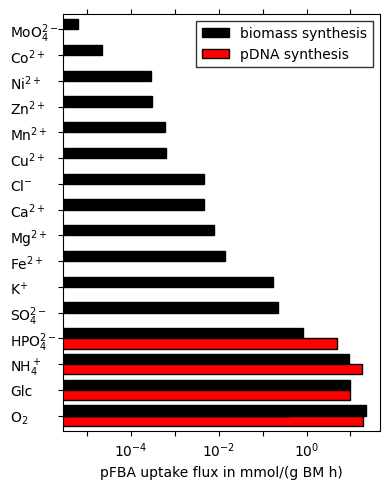

In [9]:
plt.figure(dpi=100,figsize=(4,5))
ax = plt.subplot(111)


sorted_labels = []
colors = []
for nr, metabolite in enumerate(tmp.index):
    sorted_labels = tmp.loc[metabolite,'label']
    offset= .2 # .18
    width = .4 # .35
    plt.barh(nr+offset,tmp.loc[metabolite,'flux'],facecolor='k',edgecolor='k',fill=1,height=width)
    plt.barh(nr-offset,tmp2.loc[metabolite,'flux'],facecolor='r',edgecolor='k',fill=1,height=width)
#     plt.errorbar(tmp.loc[metabolite,'flux'],nr,xerr=np.array([[tmp.loc[metabolite,'flux']-tmp.loc[metabolite,'min']],[tmp.loc[metabolite,'max']-tmp.loc[metabolite,'flux']]]),color='k',capsize=3)
plt.xscale('log')
ax.tick_params(axis='y', which='major', pad=35)
ax.set_yticks(range(tmp.shape[0]))
ax.set_yticklabels(tmp['label'].values,ha='left')
ax.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1])
ax.set_xticklabels(['',r'$10^{-4}$','',r'$10^{-2}$','',r'$10^{0}$',''])
plt.xlabel('pFBA uptake flux in mmol/(g BM h)')
ax.bar(0,0,color='k',edgecolor='k',label='biomass synthesis')
ax.bar(0,0,color='r',edgecolor='k',label='pDNA synthesis')
ax.tick_params(bottom=1,top=True,axis='x',direction='out')
ax.legend(edgecolor='k',fancybox=False)
plt.tight_layout()
ax.set_ylim(-.6,15.6)

plt.show()

# Figure 3

In [10]:
with ecoli as tmp:
    q_max100_pDNA = .1/100
    snek.set_bounds(tmp,'pDNA_synthesis',lb=q_max100_pDNA,ub=q_max100_pDNA)
    snek.set_objective(tmp,'BIOMASS_Ec_iML1515_core_75p37M','max')
    q_max100_X = tmp.slim_optimize()
    
    q_max400_pDNA = .4/100
    snek.set_bounds(tmp,'pDNA_synthesis',lb=q_max400_pDNA,ub=q_max400_pDNA)
    snek.set_objective(tmp,'BIOMASS_Ec_iML1515_core_75p37M','max')
    q_max400_X = tmp.slim_optimize()

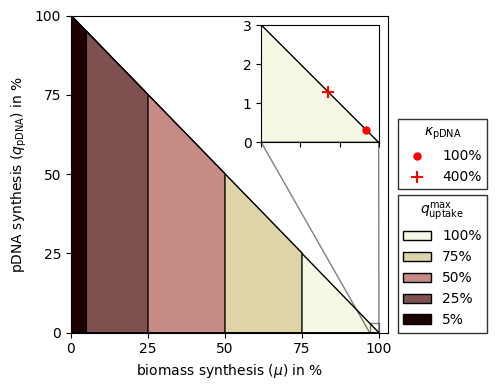

In [11]:
with ecoli as model:
        snek.set_objective(model,'BIOMASS_Ec_iML1515_core_75p37M')
        global_max_X_flux = model.slim_optimize()
        snek.set_objective(model,'pDNA_synthesis')
        global_max_P_flux = model.slim_optimize()

labels = [r'SO$_4^{2-}$ flux',r'O$_2$ flux']
j = 0
compound = "EX_so4_e"
results = {}
plt.figure(dpi=100,figsize=(5,4))
ax = plt.subplot(111,box_aspect=1)
plt.xticks([0,25,50,75,100])
plt.yticks([0,25,50,75,100])
max_x = 103
plt.xlim(0,max_x)
plt.ylim(0,100)
inset_start = .6
inset_end = (1-inset_start)+(100-max_x)/100

axins = ax.inset_axes([inset_start,inset_start, inset_end, inset_end])

max_flux = summary2.uptake_flux.loc[compound,'flux']
levels = np.flip(np.array([5,25,50,75,100])) # %
S_flux_space = levels/100*max_flux
for level, S_flux in zip(levels,S_flux_space):
    X_fluxes = []
    P_fluxes = []
    with ecoli as model:
        snek.set_bounds(model,compound,-S_flux,0)
        snek.set_objective(model,'BIOMASS_Ec_iML1515_core_75p37M')
        max_X_flux = model.slim_optimize()
    X_flux_space = np.linspace(0,max_X_flux,2)
    for tmp_X_flux in X_flux_space:
        with ecoli as model:
            snek.set_bounds(model,compound,-S_flux,0)
            snek.set_bounds(model,'BIOMASS_Ec_iML1515_core_75p37M',tmp_X_flux,tmp_X_flux)
            snek.set_objective(model,'pDNA_synthesis','max')
            tmp_P_flux = model.slim_optimize()
            X_fluxes.append(tmp_X_flux)
            P_fluxes.append(tmp_P_flux)
    for tmp_X_flux in np.flip(X_flux_space):
        with ecoli as model:
            snek.set_bounds(model,compound,-S_flux,0)
            snek.set_bounds(model,'BIOMASS_Ec_iML1515_core_75p37M',tmp_X_flux,tmp_X_flux)
            snek.set_objective(model,'pDNA_synthesis','min')
            tmp_P_flux = model.slim_optimize()
            X_fluxes.append(tmp_X_flux)
            P_fluxes.append(tmp_P_flux)
    X_fluxes = np.array(X_fluxes)/global_max_X_flux*100
    P_fluxes = np.array(P_fluxes)/global_max_P_flux*100
    results[level] = [X_fluxes,P_fluxes]
    ax.fill(X_fluxes,P_fluxes,color=matplotlib.cm.pink((level-10)/100),label=f'{level}%',edgecolor='k') # pink cividis
    axins.fill(X_fluxes,P_fluxes,color=matplotlib.cm.pink((level-10)/100),edgecolor='k') # pink cividis
        
axins.scatter(q_max100_X/global_max_X_flux*100,q_max100_pDNA/global_max_P_flux*100,marker='.',s=100,color='r',label='100%')
axins.scatter(q_max400_X/global_max_X_flux*100,q_max400_pDNA/global_max_P_flux*100,marker='+',s=80,color='r',label='400%')


ax.legend(fancybox=False,edgecolor='k',loc=(1.03,0),ncol=1,title=r'$q_{\rm uptake}^{\rm max}$')
axins.legend(fancybox=False,edgecolor='k',loc=(1.162,-.4),ncol=1,title=r'$\kappa_{\rm pDNA}$')
plt.xlabel(r'biomass synthesis ($\mu$) in %')
plt.ylabel(r'pDNA synthesis ($q_{\rm pDNA}$) in %')

# sub region of the original image
percentage = 3
x1, x2, y1, y2 = [100-percentage, 100, 0, percentage]
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([97,98,99,100])
axins.set_xticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.show()